<a href="https://colab.research.google.com/github/vaidehi2002vd/MUSHROOMS/blob/main/HST__HSC_Sources.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install photutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.0/857.0 kB 20.3 MB/s eta 0:00:00


In [ ]:
pip install reproject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.5 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=17b22d539dfd16150a2be1d6090cbaf544a1eddf0283d91bd2ff47af8d7bce57
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import sigma_clip, sigma_clipped_stats, sigma_clipping, SigmaClip
import photutils
from photutils.background import SExtractorBackground
from astropy.table import QTable, Table, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.segmentation import SourceFinder, SourceCatalog
from photutils.segmentation import deblend_sources
from astropy.wcs import WCS
from photutils.aperture import aperture_photometry, CircularAperture
from reproject import reproject_interp

After installing and importing required packages, open the HST data files.

In [ ]:
HST_5010 = 'ibjj05010_drz.fits'
HST_5020 = 'ibjj05020_drz.fits'
HST_5030 = 'ibjj05030_drz.fits'

Check which subset of the fits file has the image data. Since for this data it is in index 1, we use that as the subset.

In [ ]:
file_5010     = fits.open(HST_5010)
Subset_5010   = file_5010[1]
HST_5010_data = Subset_5010.data

file_5020     = fits.open(HST_5020)
Subset_5020   = file_5020[1]
HST_5020_data = Subset_5020.data

file_5030     = fits.open(HST_5030)
Subset_5030   = file_5030[1]
HST_5030_data = Subset_5030.data

Save the header information of HST Files.

In [ ]:
wcs_HST_5010 = WCS(Subset_5010.header)
wcs_HST_5020 = WCS(Subset_5020.header)
wcs_HST_5030 = WCS(Subset_5030.header)

Let us plot them in one picture. vmax and vmin need to be readjusted. They can be calibrated using ds9 software.

<ipython-input-23-0feb9f25ec15>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1, projection=wcs_HST_5010)
<ipython-input-23-0feb9f25ec15>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 3, 2, projection=wcs_HST_5020)
<ipython-input-23-0feb9f25ec15>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(1, 3, 3, projection=wcs_HST_5030)


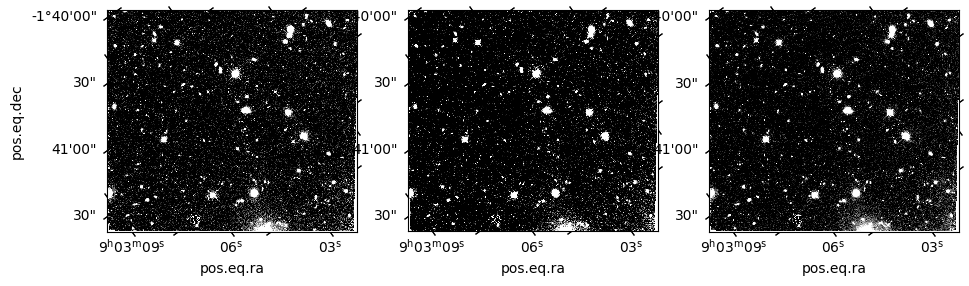

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 11))

ax1 = plt.subplot(1, 3, 1, projection=wcs_HST_5010)
plt.imshow(HST_5010_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)
ax2 = plt.subplot(1, 3, 2, projection=wcs_HST_5020)
plt.imshow(HST_5020_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.7, vmin=.62)
ax3 = plt.subplot(1, 3, 3, projection=wcs_HST_5030)
plt.imshow(HST_5030_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.7, vmin=.6)

Using sigma clip stats, find the value of standard deviation of the data.

In [ ]:
mean_5010, median_5010, std_5010 =sigma_clipped_stats(HST_5010_data, sigma=3.0)

To subtract an estimate of the background, subtract the standard deviation.

In [ ]:
HST_5010_filt = HST_5010_data - std_5010               #Modifying data to get filtered data

<ipython-input-24-f3d0d7996ee8>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5010)
<ipython-input-24-f3d0d7996ee8>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5010)


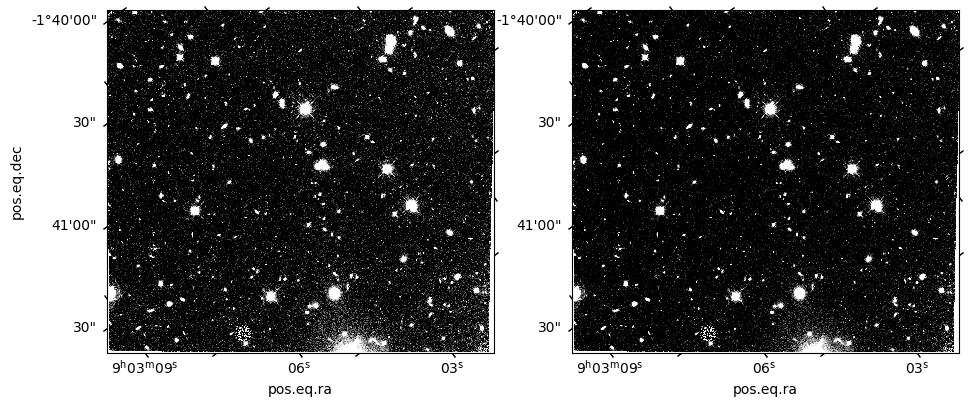

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 11))

ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5010)
plt.imshow(HST_5010_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)
ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5010)
plt.imshow(HST_5010_filt,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.13)

Now make Gaussian Kernels of (here) FWHM= 3.0 pixels and a 3X3 square box. Using this kernel, convolve the data and create a segmentation map with the help of detect_sources method. Adjust the threshold based on data.

In [ ]:
kernel_10 = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_10 = convolve(HST_5010_filt, kernel_10)
segment_map_10 = detect_sources(convolved_data_10, threshold=1.18, npixels=10)

View the segmentation image and filtered data side by side, to see for the missing sources.

<ipython-input-28-0a19762920cc>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5010)
<ipython-input-28-0a19762920cc>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5010)


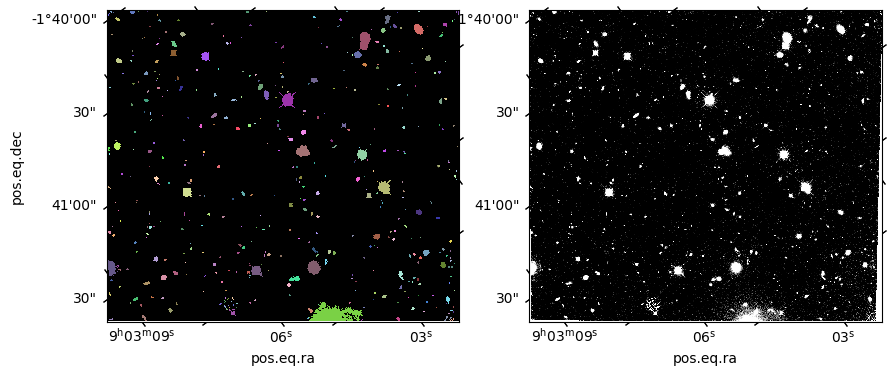

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))

ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5010)
plt.imshow(segment_map_10, origin='lower', cmap=segment_map_10.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5010)
plt.imshow(HST_5010_filt,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)

Use the deblend_sources to deblend multiple sources wrongly considered as one by detect_sources method. View both the segmentation map and segmentation deblend map.

<ipython-input-29-37f7f2524b40>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5010)
<ipython-input-29-37f7f2524b40>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5010)


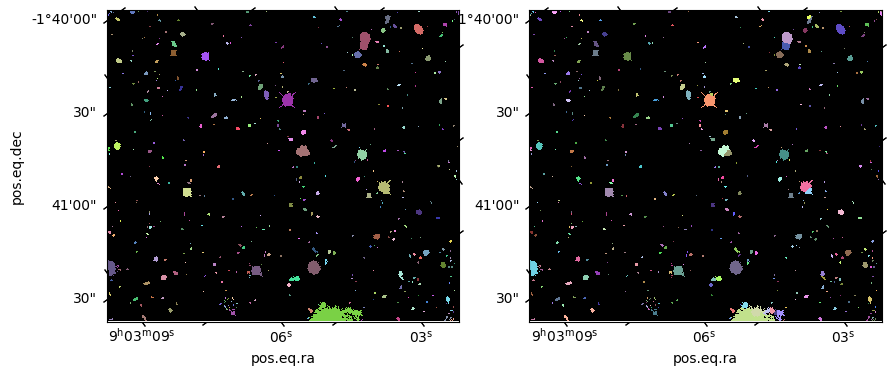

In [ ]:
segm_deblend_10 = deblend_sources(convolved_data_10, segment_map_10, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5010)
plt.imshow(segment_map_10, origin='lower', cmap=segment_map_10.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5010)
plt.imshow(segm_deblend_10,  origin='lower', cmap=segm_deblend_10.cmap, interpolation='nearest')

Make a source catalog and then convert it to a table to view it.

In [ ]:
cat_5010 = SourceCatalog(HST_5010_filt, segm_deblend_10, convolved_data=convolved_data_10, localbkg_width=5, wcs=wcs_HST_5010)
sources_5010 = cat_5010.to_table()

In [ ]:
sources_5010

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1068.596187114888,3.8358893289050084,"135.75958173210995,-1.7157157421393376",1058,1071,0,7,44.0,2.933291668156235,1.3553590586326834,43.701054849125555,0.8868482556246768,-1.0824874573946,123.30811335802078,1.1577908778190613,574.1618036681414,nan,567.4045441203893,nan
2,113.54104258822241,9.966500823767603,"135.78710983308306,-1.6957021389416547",107,123,1,17,124.0,4.785298773365102,2.31762904680149,-51.75353990625322,0.8748894083284237,0.023656037764820503,2.4737783941796154,1.1056648221442371,37.63524487348104,nan,44.482788859406,nan
3,787.1109061551782,2.945247325637009,"135.76775125423055,-1.7098952123955515",785,789,1,5,18.0,1.586695244783002,0.9192585224366914,34.473089012998585,0.8150759069725286,0.005672169666664395,0.07956750486411313,1.1522599926181867,0.8578354050131409,nan,1.9686770106529003,nan
4,899.1671966220413,5.5853511679314956,"135.76445156946494,-1.712146154063044",893,904,1,10,80.0,2.879614067345723,2.0600451517054155,-30.25265811990933,0.6987260691677297,0.02324356775744718,1.9572743390129403,1.1270109202338858,20.676419886957774,nan,19.187999706970608,nan
5,11.785225231435726,3.362325449045481,"135.7901935658247,-1.6937798342943977",6,16,2,7,23.0,3.1076350739158904,1.144554059798119,7.40749333961671,0.9297054646079924,-0.0032632724098538013,0.21018203341442598,1.1088976041130398,2.6276856422424295,nan,4.703573933867059,nan
6,619.3531506837976,8.234570230496375,"135.77249911378146,-1.7062578561048987",617,621,6,11,17.0,1.6826097729447045,1.1052484517730201,-78.52910136552809,0.754007694967007,-0.01353951523063368,0.07444147041084581,1.162270150873639,0.46160284778394,nan,-1.5916215981166046,nan
7,1069.8085678407149,11.09496120466166,"135.7593957904288,-1.7155308140742542",1068,1071,10,12,7.0,1.0203651157553866,0.7708502163419135,-26.582765727865812,0.6551889110337248,0.026955638080835342,0.20390919223427773,1.1373350284993649,0.7964540682733059,nan,-0.9664457079823435,nan
8,388.32657536531724,24.963662650452505,"135.77884131523604,-1.7009752989896645",375,396,16,37,214.0,4.918736542492684,3.226673106686295,-55.58684182554203,0.7547640814238862,-0.39066969274598007,50.98836274028701,1.1083283913047874,268.9506065578145,nan,93.36736973460896,nan


Convert it to a dataframe using to_pandas(). Now save it as a csv.

In [ ]:
source_catalog_5010 = sources_5010.to_pandas()
source_catalog_5010.to_csv('source_catalog_5010.csv')

Repeating the same steps on other 2 data files:

In [ ]:
mean_5020, median_5020, std_5020 =sigma_clipped_stats(HST_5020_data, sigma=3.0)
HST_5020_filt = HST_5020_data - std_5020               #Modifying data to get filtered data

<ipython-input-36-309e6d9d84b6>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5020)
<ipython-input-36-309e6d9d84b6>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5020)


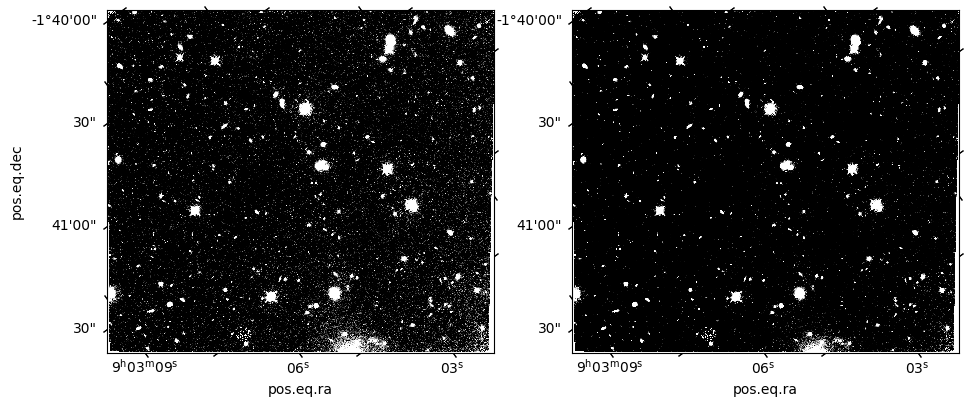

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 11))

ax1 = plt.subplot(1, 2, 1, projection=wcs_HST_5020)
plt.imshow(HST_5020_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.7, vmin=.62)
ax2 = plt.subplot(1, 2, 2, projection=wcs_HST_5020)
plt.imshow(HST_5020_filt,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.7, vmin=.62)

In [ ]:
kernel_20 = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_20 = convolve(HST_5020_filt, kernel_20)
segment_map_20 = detect_sources(convolved_data_20, threshold=.61, npixels=10)

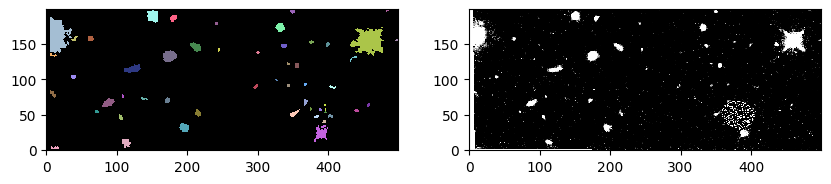

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_20[0:200, 0:500], origin='lower', cmap=segment_map_20.cmap, interpolation='nearest')
ax2.imshow(HST_5020_filt[0:200, 0:500],  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.7, vmin=.62)

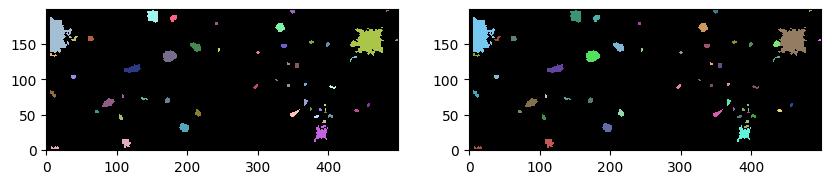

In [ ]:
segm_deblend_20 = deblend_sources(convolved_data_20, segment_map_20, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_20[0:200, 0:500], origin='lower', cmap=segment_map_20.cmap, interpolation='nearest')
ax2.imshow(segm_deblend_20[0:200, 0:500],  origin='lower', cmap=segm_deblend_20.cmap, interpolation='nearest')

In [ ]:
cat_5020 = SourceCatalog(HST_5020_filt, segm_deblend_20, convolved_data=convolved_data_20, localbkg_width=5, wcs=wcs_HST_5020)
sources_5020 = cat_5020.to_table()

In [ ]:
sources_5020

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1059.4056092500798,8.942348665927659,"135.75970570487533,-1.7153428324928686",1032,1070,0,33,529.0,9.597600600647828,7.56773510533234,-19.815678264633277,0.6150311442183356,-0.6155681432886964,14.05697706996361,0.5919630164011365,159.30430360351602,nan,151.35305743438983,nan
2,12.28764824895726,2.188409098910685,"135.79016735495756,-1.6937900243448236",7,18,1,4,24.0,3.430439265852381,1.0109335098070449,-1.0081802052180273,0.95559134614815,-0.026555451907609662,0.11341663881352071,0.5860366554636705,1.3438283048178015,nan,-0.5759752456430118,nan
3,566.3634405600682,3.820410120031809,"135.77408920047117,-1.7052508191136135",565,568,1,6,11.0,1.5256082384094454,0.6423353830748226,-64.16076574399965,0.9070441124049753,0.006414654682267429,0.06510597748576474,0.5897282929915302,0.3567677449505293,nan,1.6349458464723698,nan
4,579.3071420158478,3.3116510062654188,"135.77372496186595,-1.7055343809213932",578,581,1,6,13.0,1.8416583944596077,0.6423780217078106,-64.15958392065019,0.9371956525405509,-0.03710101404280031,0.08477832517533934,0.5839345292100366,0.5114899013402328,nan,2.0731875291805166,nan
5,804.367223883393,2.6873780802909266,"135.76722086461012,-1.7102268587410656",802,806,1,5,19.0,1.373593750953051,1.133107139496742,66.40247921737618,0.5652471779830647,-0.015192518483347017,0.05926566337471573,0.5917739369975987,0.6016263294575808,nan,0.9722913235401885,nan
6,900.2111734506828,5.495820792636993,"135.76438714399617,-1.7121362046848443",892,908,1,13,116.0,3.917383219861405,2.5586522274374905,20.043456464113937,0.7572256048453863,-0.0034772761581232103,1.0535858861686895,0.5871595152137568,12.159237353158474,nan,14.61771054575897,nan
7,959.0857620997377,4.4496804552960025,"135.76270404030618,-1.7133892800911343",956,962,1,8,22.0,2.7180335727221605,1.0529752094918154,44.0955960487595,0.9219103391779022,-0.04166012874060265,0.08839666971749671,0.5969227539580404,0.6523928328564299,nan,-1.5412691065406647,nan
8,972.1925786882093,1.9316542155542733,"135.7623768252571,-1.713734384245338",969,976,1,3,15.0,2.1147447344003134,0.7248916578243916,-7.537274740917948,0.9394158011134724,-0.007153960929554781,0.08262535644944302,0.5937135546070755,0.5239698161744766,nan,0.6119181889785352,nan


In [ ]:
source_catalog_5020 = sources_5020.to_pandas()
source_catalog_5020.to_csv('source_catalog_5020.csv')

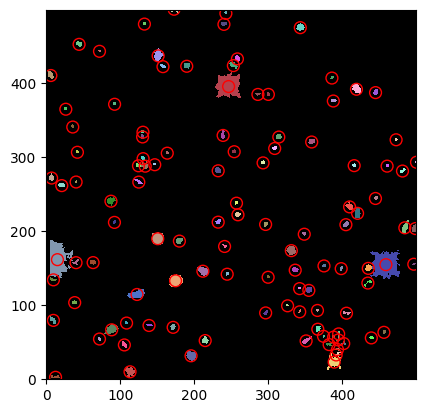

In [ ]:
positions_5020 = np.transpose((sources_5020['xcentroid'], sources_5020['ycentroid']))
apertures_5020 = CircularAperture(positions_5020, r=8.0)
plt.imshow(segm_deblend_20[0:500, 0:500],  origin='lower', cmap=segm_deblend_20.cmap, interpolation='nearest')
apertures_5020.plot(color = 'Red')
plt.show()

In [ ]:
mean_5030, median_5030, std_5030 =sigma_clipped_stats(HST_5030_data, sigma=3.0)
HST_5030_filt = HST_5030_data - std_5030               #Modifying data to get filtered data

In [ ]:
kernel_30 = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_30 = convolve(HST_5030_filt, kernel_30)
segment_map_30 = detect_sources(convolved_data_30, threshold=.6, npixels=10)

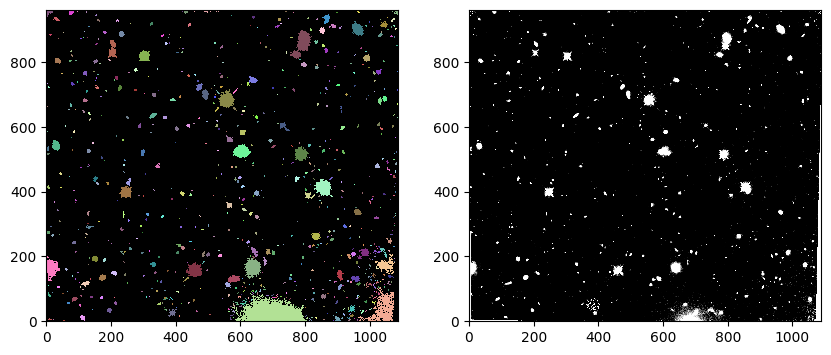

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_30, origin='lower', cmap=segment_map_30.cmap, interpolation='nearest')
ax2.imshow(HST_5030_filt,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.7, vmin=.62)

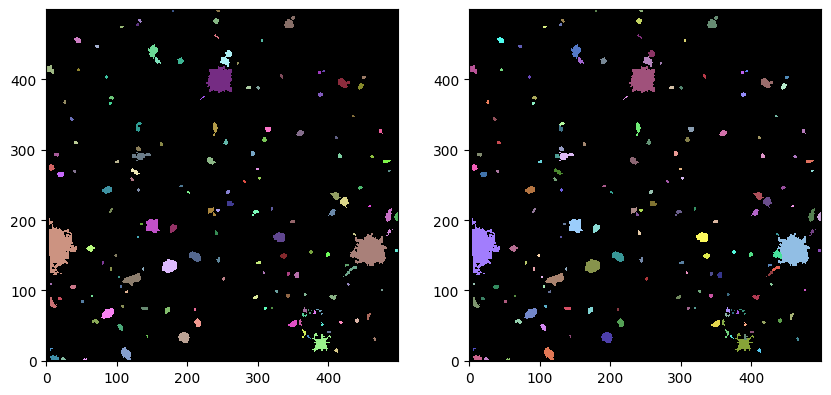

In [ ]:
segm_deblend_30 = deblend_sources(convolved_data_30, segment_map_30, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_30[0:500, 0:500], origin='lower', cmap=segment_map_30.cmap, interpolation='nearest')
ax2.imshow(segm_deblend_30[0:500, 0:500],  origin='lower', cmap=segm_deblend_30.cmap, interpolation='nearest')

In [ ]:
cat_5030 = SourceCatalog(HST_5030_filt, segm_deblend_30, convolved_data=convolved_data_30, localbkg_width=5, wcs=wcs_HST_5030)
sources_5030 = cat_5030.to_table()

In [ ]:
sources_5030

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,55.09633297783092,1.815107787341086,"135.7889735064125,-1.6947162254766273",53,57,1,3,7.0,1.5104291522020008,0.7108627521965902,3.3977309906134887,0.8823273174893097,0.010495749169162294,0.05518337791519501,0.5739788144294705,0.2689684722572565,nan,0.5608826437922425,nan
2,112.9550930565015,10.098635293752391,"135.7871259882623,-1.6956781860585393",106,120,1,19,177.0,4.786712711339198,2.9129800731429607,-57.01035845862706,0.7935113566648454,-0.011822447371299782,1.2067741302730484,0.5784948917148667,20.81794772649667,nan,21.907776055668744,nan
3,530.4611763514666,2.1514379835005117,"135.77520148804174,-1.7045797130397986",528,534,1,3,13.0,1.7438863522428312,0.6348972766249935,-6.5797561700105875,0.93137145979239,-0.004628587922742344,0.06147749308616879,0.5871022235962653,0.3248475401632245,nan,-0.1003841733663828,nan
4,814.4716091824637,3.8037943705957957,"135.76694306215055,-1.7104306738229325",810,820,1,8,47.0,3.1710446013112854,1.928970243232813,-22.747021655285636,0.7937014389278328,-0.006812163740396615,0.0495675717294215,0.5917933072149755,0.774286586195224,nan,-0.652895343181225,nan
5,887.2088893970506,3.837501876377482,"135.7648360998245,-1.711940417639024",885,889,1,7,19.0,1.9553062729210104,0.9417868895929016,64.57484494970856,0.8763598380996663,-0.009977286471460012,0.04777281938638911,0.5907618457213379,0.39207436357225944,nan,0.5848383748710415,nan
6,899.3221382866623,6.997642287926942,"135.76441967084546,-1.712100536163843",885,915,1,16,208.0,6.503390297508303,3.522667323515864,-18.563044160003336,0.8405936149569364,-0.010051438875356977,1.0484257244394624,0.5884141421987212,14.002683966546442,nan,15.472657320736005,nan
7,936.5854567126511,3.0015724973068982,"135.76342366452133,-1.7129901399551164",931,941,1,6,26.0,3.1973413658897583,0.788593895312297,24.759848739475547,0.9691070427672891,-0.008677142734972332,0.05498079669907918,0.5922143040852226,0.5971660765341511,nan,-0.22663067164468115,nan
8,961.0019924755114,2.176832150445758,"135.76273376765332,-1.7135211304632125",960,963,1,4,11.0,1.2460262605338752,0.7666886773850838,-54.995341467783405,0.7882875735544093,0.0012285638663729337,0.05200391300654017,0.5928590368416349,0.2364088115045586,nan,0.2398688196996587,nan


In [ ]:
source_catalog_5030 = sources_5030.to_pandas()
source_catalog_5030.to_csv('source_catalog_5030.csv')

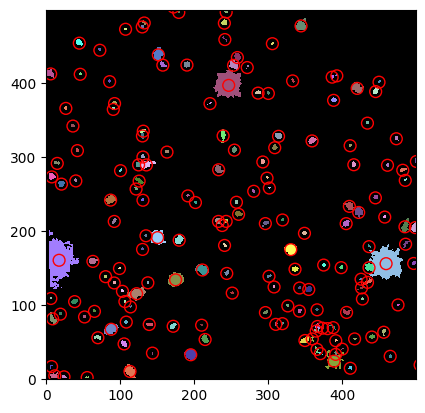

In [ ]:
positions_5030 = np.transpose((sources_5030['xcentroid'], sources_5030['ycentroid']))
apertures_5030 = CircularAperture(positions_5030, r=8.0)
plt.imshow(segm_deblend_30[0:500, 0:500],  origin='lower', cmap=segm_deblend_30.cmap, interpolation='nearest')
apertures_5030.plot(color = 'Red')
plt.show()

In [ ]:
round_x_5010 = []
round_y_5010 = []
round_x_5030 = []
round_y_5030 = []

for i in range(len(sources_5010)):
  round_x_5010.append(round(sources_5010['xcentroid'][i]))
  round_y_5010.append(round(sources_5010['ycentroid'][i]))
for i in range(len(sources_5030)):
  round_x_5030.append(round(sources_5030['xcentroid'][i]))
  round_y_5030.append(round(sources_5030['ycentroid'][i]))

In [ ]:
x_centroid_5010_5030 = []
y_centroid_5010_5030 = []
wcs_5010 = WCS(Subset_5010.header)
Flux_F110 = []
Flux_F160 = []

In [ ]:
same = []
other = []
for i in range(len(sources_5010)):
  for j in range(len(sources_5030)):
    if round_x_5010[i] == round_x_5030[j]:
      if round_y_5010[i] == round_y_5030[j] or round_y_5010[i] == round_y_5030[j]+1 or round_y_5010[i] == round_y_5030[j]-1:
        x_centroid_5010_5030.append(sources_5010['xcentroid'][i])
        y_centroid_5010_5030.append(sources_5010['ycentroid'][i])
        Flux_F110.append(sources_5010['kron_flux'][i])
        Flux_F160.append(sources_5030['kron_flux'][j])
        same.append(i)
    if round_x_5010[i] == round_x_5030[j]+1:
      if round_y_5010[i] == round_y_5030[j] or round_y_5010[i] == round_y_5030[j]+1 or round_y_5010[i] == round_y_5030[j]-1:
        x_centroid_5010_5030.append(sources_5010['xcentroid'][i])
        y_centroid_5010_5030.append(sources_5010['ycentroid'][i])
        Flux_F110.append(sources_5010['kron_flux'][i])
        Flux_F160.append(sources_5030['kron_flux'][j])
        same.append(i)
    if round_x_5010[i] == round_x_5030[j]-1:
      if round_y_5010[i] == round_y_5030[j] or round_y_5010[i] == round_y_5030[j]+1 or round_y_5010[i] == round_y_5030[j]-1:
        x_centroid_5010_5030.append(sources_5010['xcentroid'][i])
        y_centroid_5010_5030.append(sources_5010['ycentroid'][i])
        Flux_F110.append(sources_5010['kron_flux'][i])
        Flux_F160.append(sources_5030['kron_flux'][j])
        same.append(i)


In [ ]:
sky_coord = wcs_5010.pixel_to_world(x_centroid_5010_5030, y_centroid_5010_5030)
RA  = np.array(sky_coord.ra)
DEC = np.array(sky_coord.dec)

In [ ]:
sources_F110_F160 = pd.DataFrame()
sources_F110_F160['xcentroid'] = x_centroid_5010_5030
sources_F110_F160['ycentroid'] = y_centroid_5010_5030
sources_F110_F160['RA']  = RA
sources_F110_F160['DEC'] = DEC
sources_F110_F160['Flux_F110'] = Flux_F110
sources_F110_F160['Flux_F160'] = Flux_F160

In [ ]:
sources_F110_F160.to_csv('source_catalog_F110_F160.csv')

In [ ]:
for i in range(len(sources_5020)):
  if sources_5020['xcentroid'][i]>470 and sources_5020['xcentroid'][i] < 480:
    print(sources_5020['xcentroid'][i], sources_5020['ycentroid'][i])


473.00353715974103 323.50755332059566
472.1149987194309 624.5916818346886
472.3876210664474 720.6521264031236


Since the HSC files are not the same shape as HST files and the pixel size, matrices are differe==nt. Use reproject to project HSC file to HST file.

In [ ]:
filename = '6-cutout-HSC-Y-9075-pdr3_wide.fits'
open_file = fits.open(filename)
subset    = open_file[1]
data_file = subset.data
wcs_hsc = WCS(subset.header)
wcs_hst = WCS(Subset_5010.header)

array_new_Y, footprint_new_Y = reproject_interp((data_file , wcs_hsc), wcs_hst)

open_file[1].data = array_new_Y
open_file[1].header.update(wcs_hst.to_header())

filename = 'reshaped_6-cutout-HSC-Y-9075-pdr3_wide.fits'
open_file[1].writeto(filename, overwrite=True)

In [ ]:
HSC_G_name = 'reshaped_2-cutout-HSC-G-9075-pdr3_wide.fits'
HSC_R_name = 'reshaped_3-cutout-HSC-R-9075-pdr3_wide.fits'
HSC_I_name = 'reshaped_4-cutout-HSC-I-9075-pdr3_wide.fits'
HSC_Z_name = 'reshaped_5-cutout-HSC-Z-9075-pdr3_wide.fits'
HSC_Y_name = 'reshaped_6-cutout-HSC-Y-9075-pdr3_wide.fits'

In [ ]:
file_G     = fits.open(HSC_G_name)
Subset_G   = file_G[1]
HSC_G_data = Subset_G.data

file_R     = fits.open(HSC_R_name)
Subset_R   = file_R[1]
HSC_R_data = Subset_R.data

file_I     = fits.open(HSC_I_name)
Subset_I   = file_I[1]
HSC_I_data = Subset_I.data

file_Z     = fits.open(HSC_Z_name)
Subset_Z   = file_Z[1]
HSC_Z_data = Subset_Z.data

# file_Y     = fits.open(HSC_Y_name)
# Subset_Y   = file_Y[1]
# HSC_Y_data = Subset_Y.data

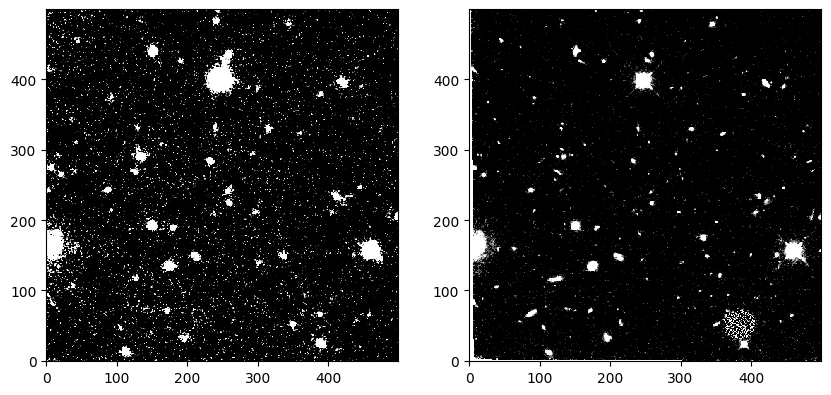

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(HSC_G_data[0:500, 0:500],  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.07, vmin=.04)
ax2.imshow(HST_5010_filt[0:500, 0:500],  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)

In [ ]:
mean_G, median_G, std_G =sigma_clipped_stats(HSC_G_data, sigma=3.0)
HSC_G_filt = HSC_G_data - std_G               #Modifying data to get filtered data

mean_R, median_R, std_R =sigma_clipped_stats(HSC_R_data, sigma=3.0)
HSC_R_filt = HSC_R_data - std_R               #Modifying data to get filtered data

mean_I, median_I, std_I =sigma_clipped_stats(HSC_I_data, sigma=3.0)
HSC_I_filt = HSC_I_data - std_I               #Modifying data to get filtered data

mean_Z, median_Z, std_Z =sigma_clipped_stats(HSC_Z_data, sigma=3.0)
HSC_Z_filt = HSC_Z_data - std_Z               #Modifying data to get filtered data

# mean_Y, median_Y, std_Y =sigma_clipped_stats(HSC_Y_data, sigma=3.0)
# HSC_Y_filt = HSC_Y_data - std_Y               #Modifying data to get filtered data

In [ ]:
kernel_G = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_G = convolve(HSC_G_filt, kernel_G)
segment_map_G = detect_sources(convolved_data_G, threshold=0.01, npixels=10)

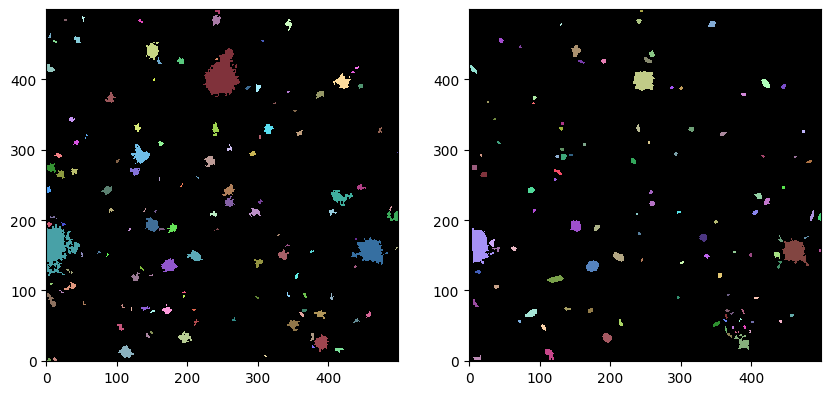

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_G[0:500, 0:500], origin='lower', cmap=segment_map_G.cmap, interpolation='nearest')
ax2.imshow(segment_map_10[0:500, 0:500],  origin='lower', cmap=segment_map_10.cmap, interpolation='nearest')

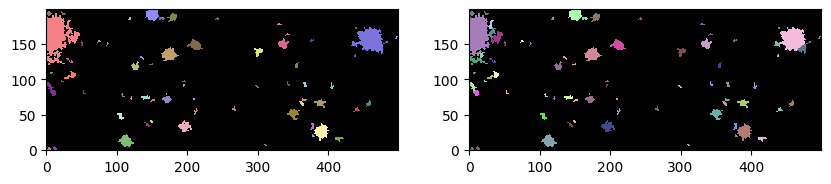

In [ ]:
segm_deblend_G = deblend_sources(convolved_data_G, segment_map_G, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_G[0:200, 0:500], origin='lower', cmap=segment_map_G.cmap, interpolation='nearest')
ax2.imshow(segm_deblend_G[0:200, 0:500],  origin='lower', cmap=segm_deblend_G.cmap, interpolation='nearest')

In [ ]:
cat_G = SourceCatalog(HSC_G_filt, segm_deblend_G, convolved_data=convolved_data_G, localbkg_width=5)
sources_G = cat_G.to_table()

In [ ]:
sources_G

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,3.303433541522234,1.2113095860498948,None,0,6,0,3,22.0,1.9094875576789416,0.913739039028288,10.757315943225295,0.878073499093958,0.028011763327814562,0.08228078878944556,-0.02508013230886793,1.242065251606944,nan,1.5892389468417172,nan
2,12.23673552336734,1.705163429501686,None,10,15,0,4,23.0,1.582395452728089,1.001265421171125,-24.602298984945694,0.7743537176003661,0.014484073735073318,0.08267135669373434,-0.026725761238485038,1.180572902840745,nan,1.8441996015098754,nan
3,591.671190475354,0.6433850230566078,None,590,594,0,2,10.0,1.1242146826133506,0.6396186432626896,-1.7300802922588405,0.8223741472579198,0.025525224589355404,0.06102788603395888,-0.013223556290305787,0.39517298092035164,nan,0.520427916378119,nan
4,726.9315347504934,1.822638602957662,None,725,729,0,3,16.0,1.2281408373405187,0.8639213360072767,15.65637497283,0.710756301434922,0.006239637261716143,0.06143271360207021,-0.009031926815696019,0.5913238729683309,nan,0.7248578657602242,nan
5,770.3586077684728,1.7888726378385613,None,767,772,0,6,12.0,2.366405573123995,0.6837189595190383,-60.02455307559837,0.9573510680163372,0.005197843290932355,0.0786152787265395,-0.013591870615099286,0.49357716462796375,nan,0.87505405548399,nan
6,746.856364759699,2.9739163287923454,None,745,750,1,5,16.0,1.712930843140706,0.8815147163432137,-20.783332887081713,0.8574161782221386,0.00698875796520796,0.062120825230389705,-0.011097566465075821,0.5638495863084032,nan,0.8477709355152747,nan
7,898.9405581462031,6.512842922308378,None,893,903,2,10,68.0,2.1521480485147553,1.7096067022566759,-33.47646210591933,0.607431245190466,0.02856653882392113,0.17522289956502335,-0.025556883667320687,5.007460058689814,nan,6.324546521217382,nan
8,112.66171498437893,12.181575562989993,None,102,123,3,21,233.0,3.372463443582388,2.738755404136996,-39.13888944824557,0.5835274300171555,0.023078666109507727,0.6142643976725414,-0.03150054014304414,35.00158197114381,nan,36.96526394077039,nan


In [ ]:
round_x_10_30 = []
round_y_10_30 = []
round_x_G = []
round_y_G = []
x_cent_110_160_G = []
y_cent_110_160_G = []
F110      = []
F160      = []
FluxG    = []
for i in range(len(sources_F110_F160)):
  round_x_10_30.append(round(sources_F110_F160['xcentroid'][i]))
  round_y_10_30.append(round(sources_F110_F160['ycentroid'][i]))
for i in range(len(sources_G)):
  round_x_G.append(round(sources_G['xcentroid'][i]))
  round_y_G.append(round(sources_G['ycentroid'][i]))

In [ ]:
same = []
for i in range(len(sources_F110_F160)):
  for j in range(len(sources_G)):
    if round_x_10_30[i] == round_x_G[j]:
      if round_y_10_30[i] == round_y_G[j] or round_y_10_30[i] == round_y_G[j]+1 or round_y_10_30[i] == round_y_G[j]-1:
        x_cent_110_160_G.append(sources_F110_F160['xcentroid'][i])
        y_cent_110_160_G.append(sources_F110_F160['ycentroid'][i])
        F110.append(sources_F110_F160['Flux_F110'][i])
        F160.append(sources_F110_F160['Flux_F160'][i])
        FluxG.append(sources_G['kron_flux'][j])
        same.append(i)
    if round_x_10_30[i] == round_x_G[j]+1:
      if round_y_10_30[i] == round_y_G[j] or round_y_10_30[i] == round_y_G[j]+1 or round_y_10_30[i] == round_y_G[j]-1:
        x_cent_110_160_G.append(sources_F110_F160['xcentroid'][i])
        y_cent_110_160_G.append(sources_F110_F160['ycentroid'][i])
        F110.append(sources_F110_F160['Flux_F110'][i])
        F160.append(sources_F110_F160['Flux_F160'][i])
        FluxG.append(sources_G['kron_flux'][j])
        same.append(i)
    if round_x_10_30[i] == round_x_G[j]-1:
      if round_y_10_30[i] == round_y_G[j] or round_y_10_30[i] == round_y_G[j]+1 or round_y_10_30[i] == round_y_G[j]-1:
        x_cent_110_160_G.append(sources_F110_F160['xcentroid'][i])
        y_cent_110_160_G.append(sources_F110_F160['ycentroid'][i])
        F110.append(sources_F110_F160['Flux_F110'][i])
        F160.append(sources_F110_F160['Flux_F160'][i])
        FluxG.append(sources_G['kron_flux'][j])
        same.append(i)


In [ ]:
sky_coord = wcs_5010.pixel_to_world(x_cent_110_160_G, y_cent_110_160_G)
RA  = np.array(sky_coord.ra)
DEC = np.array(sky_coord.dec)

sources_HST_G = pd.DataFrame()
sources_HST_G['xcentroid'] = x_cent_110_160_G
sources_HST_G['ycentroid'] = y_cent_110_160_G
sources_HST_G['RA']  = RA
sources_HST_G['DEC'] = DEC
sources_HST_G['Flux_F110'] = F110
sources_HST_G['Flux_F160'] = F160
sources_HST_G['Flux_G'] = FluxG

In [ ]:
sources_HST_G.to_csv('source_catalog_HST_HSC_G.csv')

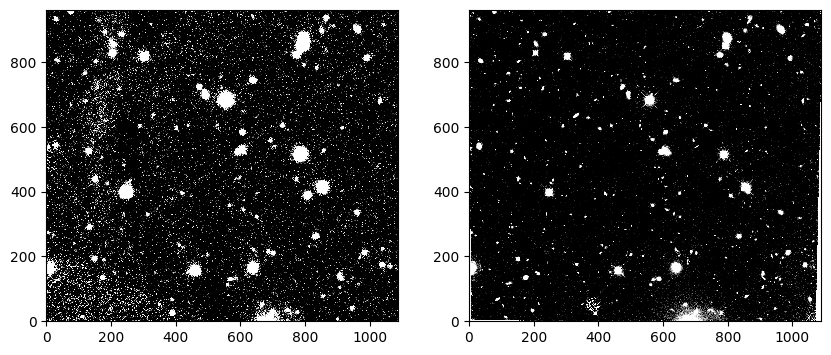

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(HSC_R_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.13, vmin=.06)
ax2.imshow(HST_5010_filt,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)

In [ ]:
kernel_R = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_R = convolve(HSC_R_filt, kernel_R)
segment_map_R = detect_sources(convolved_data_R, threshold=0.02, npixels=10)

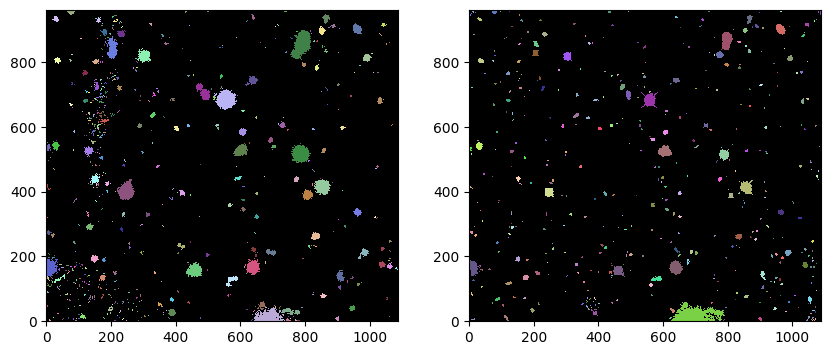

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_R, origin='lower', cmap=segment_map_R.cmap, interpolation='nearest')
ax2.imshow(segment_map_10,  origin='lower', cmap=segment_map_10.cmap, interpolation='nearest')

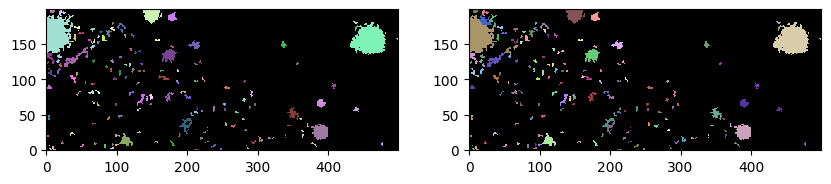

In [ ]:
segm_deblend_R = deblend_sources(convolved_data_R, segment_map_R, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_R[0:200, 0:500], origin='lower', cmap=segment_map_R.cmap, interpolation='nearest')
ax2.imshow(segm_deblend_R[0:200, 0:500],  origin='lower', cmap=segm_deblend_R.cmap, interpolation='nearest')

In [ ]:
cat_R = SourceCatalog(HSC_R_filt, segm_deblend_R, convolved_data=convolved_data_R, localbkg_width=5)
sources_R = cat_R.to_table()

In [ ]:
sources_R

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,5.243439784756029,2.293525747676088,None,4,7,0,6,14.0,2.1425682943876803,0.591976193642022,-75.07136613468174,0.9610735084094424,0.07205206609673939,0.23750864015653766,-0.06851486909590009,2.056309329609851,nan,2.6425767977389656,nan
2,10.399500744279687,2.337937699144812,None,9,13,0,5,18.0,1.821715269507444,0.8419939935529694,-57.70896248256296,0.8867765123462293,0.011140495000761488,0.20399159737930225,-0.051732784210539534,2.2328362978991247,nan,2.750655043008301,nan
3,92.95507966404584,1.7380616818078727,None,90,95,0,3,13.0,1.5384980815653408,0.6973657973401685,16.02338462912555,0.8913697099652679,0.04104136992471147,0.1838453511540293,-0.051363024743283164,1.6665993507447197,nan,1.7139403231694406,nan
4,212.73916211655393,0.46223516985851465,None,209,216,0,1,15.0,2.1134007211596986,0.489495634281227,-2.640046201014488,0.9728074939397057,0.03503977022001807,0.1950976917241661,-0.06371855419186437,2.050810790253858,nan,2.4789807664489754,nan
5,247.89166341951176,0.9065267009760691,None,246,250,0,2,11.0,0.9350227183491822,0.6920904361897857,-1.383944770265498,0.6724025163061029,0.09293203244504605,0.24363844955777453,-0.06486810599958572,1.8006692246570215,nan,2.1797282733368326,nan
6,635.019488026448,4.054664367456379,None,633,637,0,8,27.0,2.373980284632275,0.8694194137698478,78.24543814117573,0.9305249226986771,-0.049608059131183026,0.1716515158858469,0.0038091058288640955,1.4310178052950213,nan,0.924125416665426,nan
7,734.2363796378519,1.8412505231192224,None,732,736,0,5,17.0,1.6142171048111709,0.7808005222728679,-46.16072674028075,0.8752325904501534,0.004518503303634638,0.12241905589003017,-0.008014623151320552,0.9951381455569437,nan,1.0826203857537875,nan
8,745.5132026926402,2.3654733917746027,None,740,755,0,8,79.0,3.768645259498392,1.7874198892780697,-6.975215138210204,0.8803702244618792,-0.002101667844270891,0.18357491043733645,-0.004695921924597633,5.992088828963342,nan,4.585868732110695,nan


In [ ]:
catalog_HST_G = pd.read_csv('source_catalog_HST_HSC_G.csv')
catalog_HST_G = catalog_HST_G.drop(axis=1, labels = 'Unnamed: 0')

In [ ]:
round_x_R = []
round_y_R = []
round_x_10 = []
round_y_10 = []
round_x_HST_G = []
round_y_HST_G = []
x_HST_GR = []
y_HST_GR = []
F110 = []
F160 = []
F_G  = []
F_R  = []
for i in range(len(sources_R)):
  round_x_R.append(round(sources_R['xcentroid'][i]))
  round_y_R.append(round(sources_R['ycentroid'][i]))
for i in range(len(catalog_HST_G)):
  round_x_HST_G.append(round(catalog_HST_G['xcentroid'][i]))
  round_y_HST_G.append(round(catalog_HST_G['ycentroid'][i]))

In [ ]:
same  = []
for i in range(len(catalog_HST_G)):
  for j in range(len(sources_R)):
    if round_x_HST_G[i]==round_x_R[j]:
      if round_y_HST_G[i]==round_y_R[j] or round_y_HST_G[i]==round_y_R[j]+1 or round_y_HST_G[i]==round_y_R[j]-1:
        x_HST_GR.append(catalog_HST_G['xcentroid'][i])
        y_HST_GR.append(catalog_HST_G['ycentroid'][i])
        F110.append(catalog_HST_G['Flux_F110'][i])
        F160.append(catalog_HST_G['Flux_F160'][i])
        F_G.append(catalog_HST_G['Flux_G'][i])
        F_R.append(sources_R['kron_flux'][j])
        same.append(i)
    if round_x_HST_G[i]==round_x_R[j]+1:
      if round_y_HST_G[i]==round_y_R[j] or round_y_HST_G[i]==round_y_R[j]+1 or round_y_HST_G[i]==round_y_R[j]-1:
        x_HST_GR.append(catalog_HST_G['xcentroid'][i])
        y_HST_GR.append(catalog_HST_G['ycentroid'][i])
        F110.append(catalog_HST_G['Flux_F110'][i])
        F160.append(catalog_HST_G['Flux_F160'][i])
        F_G.append(catalog_HST_G['Flux_G'][i])
        F_R.append(sources_R['kron_flux'][j])
        same.append(i)
    if round_x_HST_G[i]==round_x_R[j]-1:
      if round_y_HST_G[i]==round_y_R[j] or round_y_HST_G[i]==round_y_R[j]+1 or round_y_HST_G[i]==round_y_R[j]-1:
        x_HST_GR.append(catalog_HST_G['xcentroid'][i])
        y_HST_GR.append(catalog_HST_G['ycentroid'][i])
        F110.append(catalog_HST_G['Flux_F110'][i])
        F160.append(catalog_HST_G['Flux_F160'][i])
        F_G.append(catalog_HST_G['Flux_G'][i])
        F_R.append(sources_R['kron_flux'][j])
        same.append(i)

In [ ]:
len(same)

123

In [ ]:
sky_coord = wcs_5010.pixel_to_world(x_HST_GR, y_HST_GR)
RA  = np.array(sky_coord.ra)
DEC = np.array(sky_coord.dec)

sources_HST_GR = pd.DataFrame()
sources_HST_GR['xcentroid'] = x_HST_GR
sources_HST_GR['ycentroid'] = y_HST_GR
sources_HST_GR['RA']  = RA
sources_HST_GR['DEC'] = DEC
sources_HST_GR['Flux_F110'] = F110
sources_HST_GR['Flux_F160'] = F160
sources_HST_GR['Flux_G'] = F_G
sources_HST_GR['Flux_R'] = F_R

In [ ]:
sources_HST_GR.to_csv('source_catalog_HST_HSC_G_R.csv')

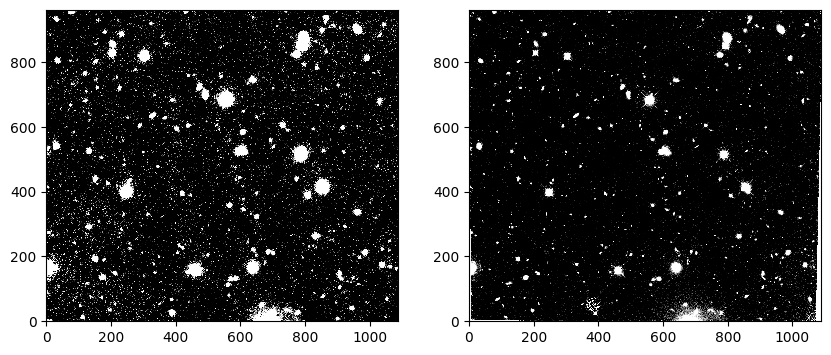

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(HSC_I_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.13, vmin=.06)
ax2.imshow(HST_5010_filt,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)

In [ ]:
kernel_I = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_I = convolve(HSC_I_filt, kernel_I)
segment_map_I = detect_sources(convolved_data_I, threshold=0.02, npixels=10)

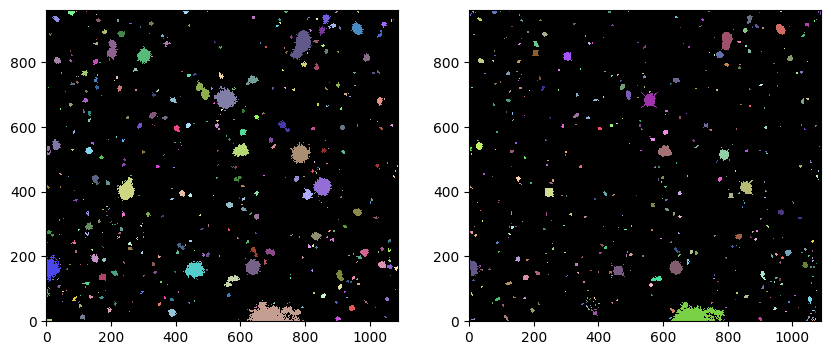

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_I, origin='lower', cmap=segment_map_I.cmap, interpolation='nearest')
ax2.imshow(segment_map_10,  origin='lower', cmap=segment_map_10.cmap, interpolation='nearest')

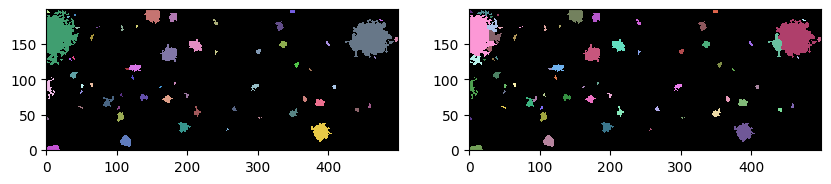

In [ ]:
segm_deblend_I = deblend_sources(convolved_data_I, segment_map_I, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_I[0:200, 0:500], origin='lower', cmap=segment_map_I.cmap, interpolation='nearest')
ax2.imshow(segm_deblend_I[0:200, 0:500],  origin='lower', cmap=segm_deblend_I.cmap, interpolation='nearest')

In [ ]:
cat_I = SourceCatalog(HSC_I_filt, segm_deblend_I, convolved_data=convolved_data_I, localbkg_width=5)
sources_I = cat_I.to_table()

In [ ]:
round_x_I = []
round_y_I = []
round_x_10 = []
round_y_10 = []
round_x_HST_G = []
round_y_HST_G = []
round_x_HST_GR = []
round_y_HST_GR = []
F110 = []
F160 = []
F_G  = []
F_R  = []
F_I  = []
x_HST_GI = []
y_HST_GI = []
for i in range(len(catalog_HST_G)):
  round_x_HST_G.append(round(catalog_HST_G['xcentroid'][i]))
  round_y_HST_G.append(round(catalog_HST_G['ycentroid'][i]))
for i in range(len(sources_I)):
  round_x_I.append(round(sources_I['xcentroid'][i]))
  round_y_I.append(round(sources_I['ycentroid'][i]))
for i in range(len(sources_5010)):
  round_x_10.append(round(sources_5010['xcentroid'][i]))
  round_y_10.append(round(sources_5010['ycentroid'][i]))

same = []
for i in range(len(sources_I)):
  for j in range(len(sources_5010)):
    if round_x_I[i]==round_x_10[j]:
      if round_y_I[i]==round_y_10[j] or round_y_I[i]==round_y_10[j]+1 or round_y_I[i]==round_y_10[j]-1:
        same.append(i)
    if round_x_I[i]==round_x_10[j]+1:
      if round_y_I[i]==round_y_10[j] or round_y_I[i]==round_y_10[j]+1 or round_y_I[i]==round_y_10[j]-1:
        same.append(i)
    if round_x_I[i]==round_x_10[j]-1:
      if round_y_I[i]==round_y_10[j] or round_y_I[i]==round_y_10[j]+1 or round_y_I[i]==round_y_10[j]-1:
        same.append(i)


In [ ]:
same  = []
for i in range(len(catalog_HST_G)):
  for j in range(len(sources_I)):
    if round_x_HST_G[i]==round_x_I[j]:
      if round_y_HST_G[i]==round_y_I[j] or round_y_HST_G[i]==round_y_I[j]+1 or round_y_HST_G[i]==round_y_I[j]-1:
        x_HST_GI.append(catalog_HST_G['xcentroid'][i])
        y_HST_GI.append(catalog_HST_G['ycentroid'][i])
        F110.append(catalog_HST_G['Flux_F110'][i])
        F160.append(catalog_HST_G['Flux_F160'][i])
        F_G.append(catalog_HST_G['Flux_G'][i])
        F_I.append(sources_I['kron_flux'][j])
        same.append(i)
    if round_x_HST_G[i]==round_x_I[j]+1:
      if round_y_HST_G[i]==round_y_I[j] or round_y_HST_G[i]==round_y_I[j]+1 or round_y_HST_G[i]==round_y_I[j]-1:
        x_HST_GI.append(catalog_HST_G['xcentroid'][i])
        y_HST_GI.append(catalog_HST_G['ycentroid'][i])
        F110.append(catalog_HST_G['Flux_F110'][i])
        F160.append(catalog_HST_G['Flux_F160'][i])
        F_G.append(catalog_HST_G['Flux_G'][i])
        F_I.append(sources_I['kron_flux'][j])
        same.append(i)
    if round_x_HST_G[i]==round_x_I[j]-1:
      if round_y_HST_G[i]==round_y_I[j] or round_y_HST_G[i]==round_y_I[j]+1 or round_y_HST_G[i]==round_y_I[j]-1:
        x_HST_GI.append(catalog_HST_G['xcentroid'][i])
        y_HST_GI.append(catalog_HST_G['ycentroid'][i])
        F110.append(catalog_HST_G['Flux_F110'][i])
        F160.append(catalog_HST_G['Flux_F160'][i])
        F_G.append(catalog_HST_G['Flux_G'][i])
        F_I.append(sources_I['kron_flux'][j])
        same.append(i)

In [ ]:
sky_coord = wcs_5010.pixel_to_world(x_HST_GI, y_HST_GI)
RA  = np.array(sky_coord.ra)
DEC = np.array(sky_coord.dec)

sources_HST_GI = pd.DataFrame()
sources_HST_GI['xcentroid'] = x_HST_GI
sources_HST_GI['ycentroid'] = y_HST_GI
sources_HST_GI['RA']  = RA
sources_HST_GI['DEC'] = DEC
sources_HST_GI['Flux_F110'] = F110
sources_HST_GI['Flux_F160'] = F160
sources_HST_GI['Flux_G'] = F_G
sources_HST_GI['Flux_I'] = F_I
sources_HST_GI

,xcentroid,ycentroid,RA,DEC,Flux_F110,Flux_F160,Flux_G,Flux_I
0,899.167197,5.585351,135.764452,-1.712146,19.188000,15.472657,6.324547,31.590740
1,388.326575,24.963663,135.778841,-1.700975,93.367370,-13.623038,54.548946,323.100406
2,195.209161,32.436358,135.784278,-1.696748,48.406570,21.930357,15.871256,29.088140
3,943.573875,38.092954,135.762490,-1.712128,94.774207,44.464338,17.435817,123.125028
4,105.186832,47.134961,135.786579,-1.694453,2.756101,9.231021,3.588103,14.141522
...,...,...,...,...,...,...,...,...
189,852.233855,413.065581,135.757344,-1.699377,5198.397773,2961.940561,964.258982,6526.494914
190,5.189517,533.989305,135.779359,-1.678284,20.479864,12.407621,29.679067,32.233343
191,555.935807,680.777381,135.760361,-1.685474,7472.185133,4065.366315,2927.631035,10585.285084
192,790.724429,847.930998,135.750089,-1.685513,2403.893117,1183.114212,1745.825510,4262.114868


In [ ]:
sources_HST_GI.to_csv('source_catalog_HST_GI.csv')
catalog_HST_GI = pd.read_csv('source_catalog_HST_GI.csv')
catalog_HST_GI = catalog_HST_GI.drop(axis=1, labels='Unnamed: 0')

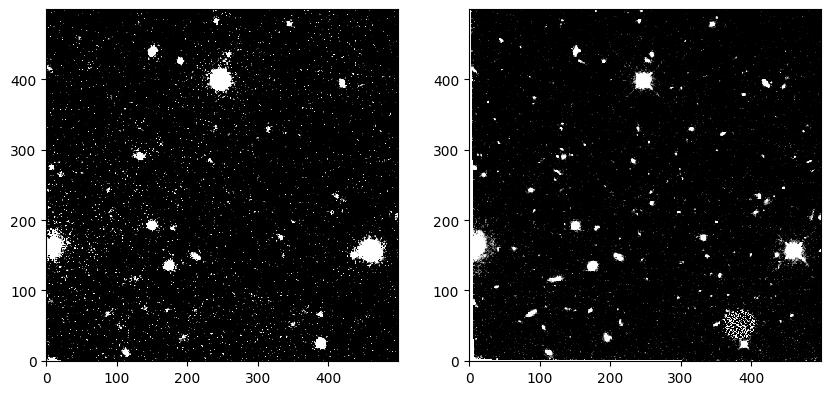

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(HSC_Z_data[0:500, 0:500],  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.35, vmin=.2)
ax2.imshow(HST_5010_filt[0:500, 0:500],  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)

In [ ]:
kernel_Z = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_Z = convolve(HSC_Z_filt, kernel_Z)
segment_map_Z = detect_sources(convolved_data_Z, threshold=0.02, npixels=10)

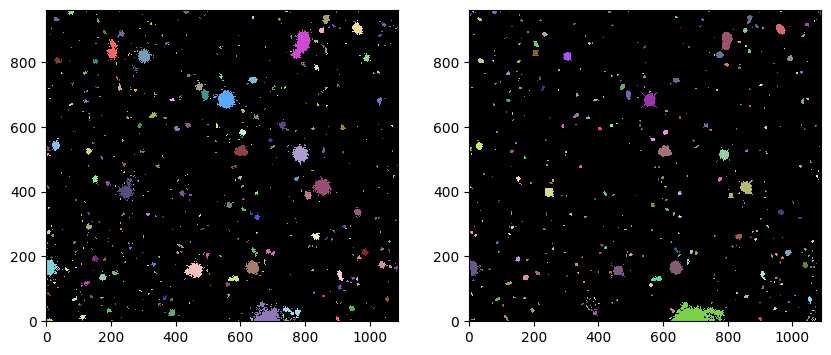

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_Z, origin='lower', cmap=segment_map_Z.cmap, interpolation='nearest')
ax2.imshow(segment_map_10,  origin='lower', cmap=segment_map_10.cmap, interpolation='nearest')

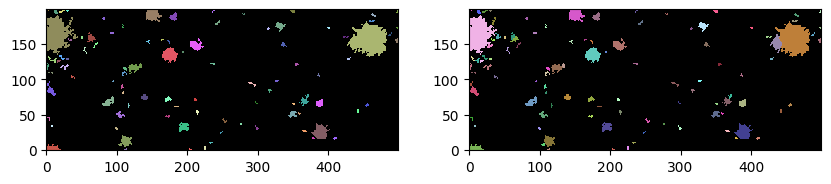

In [ ]:
segm_deblend_Z = deblend_sources(convolved_data_Z, segment_map_Z, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_Z[0:200, 0:500], origin='lower', cmap=segment_map_Z.cmap, interpolation='nearest')
ax2.imshow(segm_deblend_Z[0:200, 0:500],  origin='lower', cmap=segm_deblend_Z.cmap, interpolation='nearest')

In [ ]:
cat_Z = SourceCatalog(HSC_Z_filt, segm_deblend_Z, convolved_data=convolved_data_Z, localbkg_width=5)
sources_Z = cat_Z.to_table()

In [ ]:
round_x_Z = []
round_y_Z = []
round_x_10 = []
round_y_10 = []
round_x_HST_GI = []
round_y_HST_GI = []

F110 = []
F160 = []
F_G  = []
F_R  = []
F_I  = []
F_Z  = []
x_HST_GIZ = []
y_HST_GIZ = []
for i in range(len(catalog_HST_GI)):
  round_x_HST_GI.append(round(catalog_HST_GI['xcentroid'][i]))
  round_y_HST_GI.append(round(catalog_HST_GI['ycentroid'][i]))
for i in range(len(sources_Z)):
  round_x_Z.append(round(sources_Z['xcentroid'][i]))
  round_y_Z.append(round(sources_Z['ycentroid'][i]))
for i in range(len(sources_5010)):
  round_x_10.append(round(sources_5010['xcentroid'][i]))
  round_y_10.append(round(sources_5010['ycentroid'][i]))

same = []
for i in range(len(sources_Z)):
  for j in range(len(sources_5010)):
    if round_x_Z[i]==round_x_10[j]:
      if round_y_Z[i]==round_y_10[j] or round_y_Z[i]==round_y_10[j]+1 or round_y_Z[i]==round_y_10[j]-1:
        same.append(i)
    if round_x_Z[i]==round_x_10[j]+1:
      if round_y_Z[i]==round_y_10[j] or round_y_Z[i]==round_y_10[j]+1 or round_y_Z[i]==round_y_10[j]-1:
        same.append(i)
    if round_x_Z[i]==round_x_10[j]-1:
      if round_y_Z[i]==round_y_10[j] or round_y_Z[i]==round_y_10[j]+1 or round_y_Z[i]==round_y_10[j]-1:
        same.append(i)


In [ ]:
same  = []
for i in range(len(catalog_HST_GI)):
  for j in range(len(sources_Z)):
    if round_x_HST_GI[i]==round_x_Z[j]:
      if round_y_HST_GI[i]==round_y_Z[j] or round_y_HST_GI[i]==round_y_Z[j]+1 or round_y_HST_GI[i]==round_y_Z[j]-1:
        x_HST_GIZ.append(catalog_HST_GI['xcentroid'][i])
        y_HST_GIZ.append(catalog_HST_GI['ycentroid'][i])
        F110.append(catalog_HST_GI['Flux_F110'][i])
        F160.append(catalog_HST_GI['Flux_F160'][i])
        F_G.append(catalog_HST_GI['Flux_G'][i])
        F_I.append(catalog_HST_GI['Flux_I'][i])
        F_Z.append(sources_Z['kron_flux'][j])
        same.append(i)
    if round_x_HST_GI[i]==round_x_Z[j]+1:
      if round_y_HST_GI[i]==round_y_Z[j] or round_y_HST_GI[i]==round_y_Z[j]+1 or round_y_HST_GI[i]==round_y_Z[j]-1:
        x_HST_GIZ.append(catalog_HST_GI['xcentroid'][i])
        y_HST_GIZ.append(catalog_HST_GI['ycentroid'][i])
        F110.append(catalog_HST_GI['Flux_F110'][i])
        F160.append(catalog_HST_GI['Flux_F160'][i])
        F_G.append(catalog_HST_GI['Flux_G'][i])
        F_I.append(catalog_HST_GI['Flux_I'][i])
        F_Z.append(sources_Z['kron_flux'][j])
        same.append(i)
    if round_x_HST_GI[i]==round_x_Z[j]-1:
      if round_y_HST_GI[i]==round_y_Z[j] or round_y_HST_GI[i]==round_y_Z[j]+1 or round_y_HST_GI[i]==round_y_Z[j]-1:
        x_HST_GIZ.append(catalog_HST_GI['xcentroid'][i])
        y_HST_GIZ.append(catalog_HST_GI['ycentroid'][i])
        F110.append(catalog_HST_GI['Flux_F110'][i])
        F160.append(catalog_HST_GI['Flux_F160'][i])
        F_G.append(catalog_HST_GI['Flux_G'][i])
        F_I.append(catalog_HST_GI['Flux_I'][i])
        F_Z.append(sources_Z['kron_flux'][j])
        same.append(i)

In [ ]:
sky_coord = wcs_5010.pixel_to_world(x_HST_GIZ, y_HST_GIZ)
RA  = np.array(sky_coord.ra)
DEC = np.array(sky_coord.dec)

sources_HST_GIZ = pd.DataFrame()
sources_HST_GIZ['xcentroid'] = x_HST_GIZ
sources_HST_GIZ['ycentroid'] = y_HST_GIZ
sources_HST_GIZ['RA']  = RA
sources_HST_GIZ['DEC'] = DEC
sources_HST_GIZ['Flux_F110'] = F110
sources_HST_GIZ['Flux_F160'] = F160
sources_HST_GIZ['Flux_G'] = F_G
sources_HST_GIZ['Flux_I'] = F_I
sources_HST_GIZ['Flux_Z'] = F_Z

sources_HST_GIZ.to_csv('source_catalog_HST_GIZ.csv')

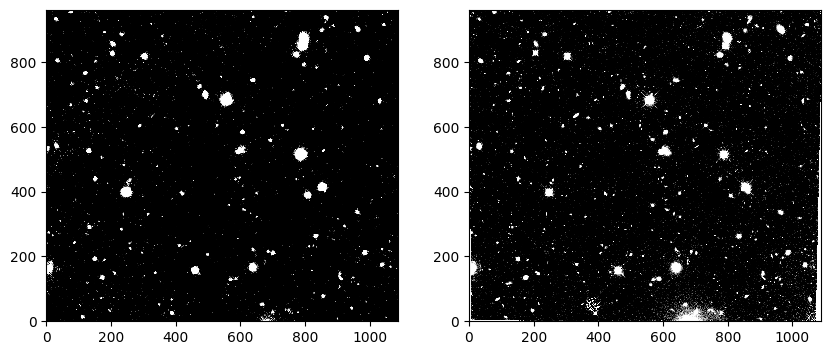

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(HSC_G_data,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=.13, vmin=.06)
ax2.imshow(HST_5010_filt,  origin='lower', cmap='Greys_r',interpolation='nearest', vmax=1.3, vmin=1.15)

In [ ]:
kernel_Y = make_2dgaussian_kernel(fwhm=3.0, size=3)
convolved_data_Y = convolve(HSC_Y_filt, kernel_Y)
segment_map_Y = detect_sources(convolved_data_Y, threshold=0.02, npixels=10)

NameError: ignored

NameError: ignored

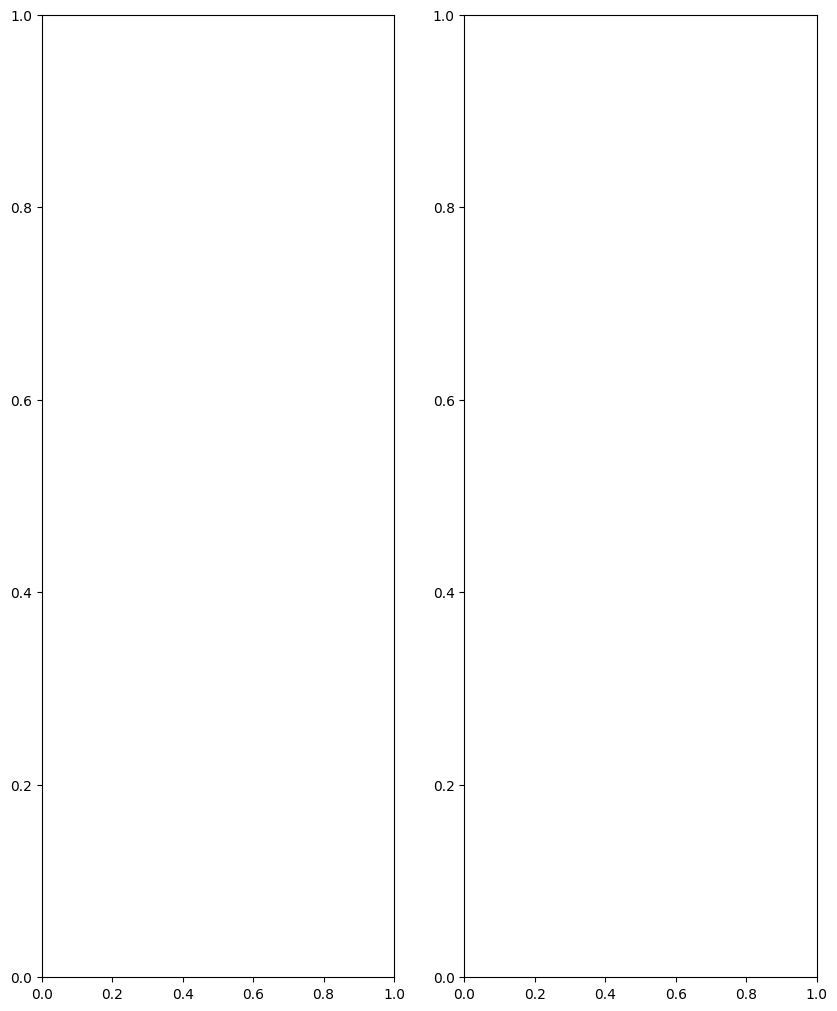

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_Y, origin='lower', cmap=segment_map_Y.cmap, interpolation='nearest')
ax2.imshow(segment_map_10,  origin='lower', cmap=segment_map_10.cmap, interpolation='nearest')

In [ ]:
segm_deblend_Y = deblend_sources(convolved_data_Y, segment_map_Y, npixels=15, nlevels=32, contrast=0.001, progress_bar=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(segment_map_Y[0:200, 0:500], origin='lower', cmap=segment_map_Y.cmap, interpolation='nearest')
ax2.imshow(segm_deblend_Y[0:200, 0:500],  origin='lower', cmap=segm_deblend_Y.cmap, interpolation='nearest')

NameError: ignored

In [ ]:
cat_Y = SourceCatalog(HSC_Y_filt, segm_deblend_Y, convolved_data=convolved_data_Y, localbkg_width=5)
sources_Y = cat_Y.to_table()

In [ ]:
sources_Y
catalog_HST_GIZ = pd.read_csv('source_catalog_HST_GIZ.csv')
catalog_HST_GIZ = catalog_HST_GIZ.drop(axis=1, labels='Unnamed: 0')

In [ ]:
round_x_Y = []
round_y_Y = []
round_x_10 = []
round_y_10 = []
round_x_HST_GIZ = []
round_y_HST_GIZ = []

F110 = []
F160 = []
F_G  = []
F_R  = []
F_I  = []
F_Z  = []
F_Y  = []
x_HST_GIZY = []
y_HST_GIZY = []
for i in range(len(catalog_HST_GIZ)):
  round_x_HST_GIZ.append(round(catalog_HST_GIZ['xcentroid'][i]))
  round_y_HST_GIZ.append(round(catalog_HST_GIZ['ycentroid'][i]))
for i in range(len(sources_Y)):
  round_x_Y.append(round(sources_Y['xcentroid'][i]))
  round_y_Y.append(round(sources_Y['ycentroid'][i]))
for i in range(len(sources_5010)):
  round_x_10.append(round(sources_5010['xcentroid'][i]))
  round_y_10.append(round(sources_5010['ycentroid'][i]))

same = []
for i in range(len(sources_Y)):
  for j in range(len(sources_5010)):
    if round_x_Y[i]==round_x_10[j]:
      if round_y_Y[i]==round_y_10[j] or round_y_Y[i]==round_y_10[j]+1 or round_y_Y[i]==round_y_10[j]-1:
        same.append(i)
    if round_x_Y[i]==round_x_10[j]+1:
      if round_y_Y[i]==round_y_10[j] or round_y_Y[i]==round_y_10[j]+1 or round_y_Y[i]==round_y_10[j]-1:
        same.append(i)
    if round_x_Y[i]==round_x_10[j]-1:
      if round_y_Y[i]==round_y_10[j] or round_y_Y[i]==round_y_10[j]+1 or round_y_Y[i]==round_y_10[j]-1:
        same.append(i)

In [ ]:
same  = []
for i in range(len(catalog_HST_GIZ)):
  for j in range(len(sources_Y)):
    if round_x_HST_GIZ[i]==round_x_Y[j]:
      if round_y_HST_GIZ[i]==round_y_Y[j] or round_y_HST_GIZ[i]==round_y_Y[j]+1 or round_y_HST_GIZ[i]==round_y_Y[j]-1:
        x_HST_GIZY.append(catalog_HST_GIZ['xcentroid'][i])
        y_HST_GIZY.append(catalog_HST_GIZ['ycentroid'][i])
        F110.append(catalog_HST_GIZ['Flux_F110'][i])
        F160.append(catalog_HST_GIZ['Flux_F160'][i])
        F_G.append(catalog_HST_GIZ['Flux_G'][i])
        F_I.append(catalog_HST_GIZ['Flux_I'][i])
        F_Z.append(catalog_HST_GIZ['Flux_Z'][i])
        F_Y.append(sources_Y['kron_flux'][j])
        same.append(i)
    if round_x_HST_GIZ[i]==round_x_Y[j]:
      if round_y_HST_GIZ[i]==round_y_Y[j] or round_y_HST_GIZ[i]==round_y_Y[j]+1 or round_y_HST_GIZ[i]==round_y_Y[j]-1:
        x_HST_GIZY.append(catalog_HST_GIZ['xcentroid'][i])
        y_HST_GIZY.append(catalog_HST_GIZ['ycentroid'][i])
        F110.append(catalog_HST_GIZ['Flux_F110'][i])
        F160.append(catalog_HST_GIZ['Flux_F160'][i])
        F_G.append(catalog_HST_GIZ['Flux_G'][i])
        F_I.append(catalog_HST_GIZ['Flux_I'][i])
        F_Z.append(catalog_HST_GIZ['Flux_Z'][i])
        F_Y.append(sources_Y['kron_flux'][j])
        same.append(i)
    if round_x_HST_GIZ[i]==round_x_Y[j]:
      if round_y_HST_GIZ[i]==round_y_Y[j] or round_y_HST_GIZ[i]==round_y_Y[j]+1 or round_y_HST_GIZ[i]==round_y_Y[j]-1:
        x_HST_GIZY.append(catalog_HST_GIZ['xcentroid'][i])
        y_HST_GIZY.append(catalog_HST_GIZ['ycentroid'][i])
        F110.append(catalog_HST_GIZ['Flux_F110'][i])
        F160.append(catalog_HST_GIZ['Flux_F160'][i])
        F_G.append(catalog_HST_GIZ['Flux_G'][i])
        F_I.append(catalog_HST_GIZ['Flux_I'][i])
        F_Z.append(catalog_HST_GIZ['Flux_Z'][i])
        F_Y.append(sources_Y['kron_flux'][j])
        same.append(i)

In [ ]:
sky_coord = wcs_5010.pixel_to_world(x_HST_GIZY, y_HST_GIZY)
RA  = np.array(sky_coord.ra)
DEC = np.array(sky_coord.dec)

sources_HST_GIZY = pd.DataFrame()
sources_HST_GIZY['xcentroid'] = x_HST_GIZY
sources_HST_GIZY['ycentroid'] = y_HST_GIZY
sources_HST_GIZY['RA']  = RA
sources_HST_GIZY['DEC'] = DEC
sources_HST_GIZY['Flux_F110'] = F110
sources_HST_GIZY['Flux_F160'] = F160
sources_HST_GIZY['Flux_G'] = F_G
sources_HST_GIZY['Flux_I'] = F_I
sources_HST_GIZY['Flux_Z'] = F_Z
sources_HST_GIZY['Flux_Y'] = F_Y

sources_HST_GIZY.to_csv('source_catalog_HST_GIZY.csv')

In [ ]:
filename = '6-cutout-HSC-Y-9075-pdr3_wide.fits'
open_file = fits.open(filename)
subset    = open_file[1]
data_file = subset.data
wcs_hsc = WCS(subset.header)
wcs_hst = WCS(Subset_5010.header)

array_new_Y, footprint_new_Y = reproject_interp((data_file , wcs_hsc), wcs_hst)

open_file[1].data = array_new_Y
open_file[1].header.update(wcs_hst.to_header())

filename = 'reshaped_6-cutout-HSC-Y-9075-pdr3_wide.fits'
open_file[1].writeto(filename, overwrite=True)

In [ ]:
array_new_Y, footprint_new_Y = reproject_interp((data_file , wcs_hsc), wcs_hst)

In [ ]:
open_file[1].data = array_new_Y
open_file[1].header.update(wcs_hst.to_header())

In [ ]:
filename = 'reshaped_6-cutout-HSC-Y-9075-pdr3_wide.fits'
open_file[1].writeto(filename, overwrite=True)